In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [26]:
# code adapted from ChatGPT

# Define your neural network model
class BFS_NN(nn.Module):
    def __init__(self):
        super(BFS_NN, self).__init__()

        self.step1 = nn.Linear(3, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 4, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = BFS_NN()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        scheduler.step()
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [27]:
df = pd.read_csv("../Data_Generation/Data_files/bfs_heisenberg_data.csv")
df = df.drop("num_steps", axis=1)
random.seed(42)
np.random.seed(42)
reordered = df.sample(frac=1).reset_index(drop=True)
bound = int(reordered.shape[0] * 0.6)
plus_one = bound+1

train = reordered.iloc[1:bound]
test_df = reordered.iloc[plus_one:reordered.shape[0]]

In [28]:
just_input = train.drop('last_matrix', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())

In [29]:
desired_output = torch.tensor(train['last_matrix'].tolist(), dtype=torch.float32).long()

In [30]:
# Train the model
trained_model = train_model(input_data, desired_output, 500, learning_rate=0.0005, viz_accuracy=True)

C:\Users\16089\AppData\Local\Temp\ipykernel_27912\4197732341.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 136.53329300880432
Epoch [1/500], Loss: 1.1977
total loss: 115.45598608255386
Epoch [2/500], Loss: 1.0128
total loss: 112.67326992750168
Epoch [3/500], Loss: 0.9884
total loss: 111.84602528810501
Epoch [4/500], Loss: 0.9811
total loss: 111.26623046398163
Epoch [5/500], Loss: 0.9760
total loss: 110.89439803361893
Epoch [6/500], Loss: 0.9728
total loss: 110.67613279819489
Epoch [7/500], Loss: 0.9708
total loss: 110.40798145532608
Epoch [8/500], Loss: 0.9685
total loss: 110.21721351146698
Epoch [9/500], Loss: 0.9668
total loss: 110.01156461238861
Epoch [10/500], Loss: 0.9650
total loss: 109.83109021186829
Epoch [11/500], Loss: 0.9634
total loss: 109.7098770737648
Epoch [12/500], Loss: 0.9624
total loss: 109.40137439966202
Epoch [13/500], Loss: 0.9597
total loss: 109.23484981060028
Epoch [14/500], Loss: 0.9582
total loss: 108.78585404157639
Epoch [15/500], Loss: 0.9543
total loss: 108.55181592702866
Epoch [16/500], Loss: 0.9522
total loss: 108.18222028017044
Epoch [17/500], Los

KeyboardInterrupt: 

In [ ]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [ ]:
just_input_test = test_df.drop('last_matrix', axis=1)

input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last_matrix'].tolist(), dtype=torch.float32).long()

In [ ]:
# performance on test and train is almost exactly the same (this is the training dataset)
test_model(trained_model, input_data, torch.tensor(train['last_matrix'].tolist(), dtype=torch.float32).long())

C:\Users\16089\AppData\Local\Temp\ipykernel_27912\875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.9728096127510071

In [ ]:
test_model(trained_model, input_data_test, desired_output)

C:\Users\16089\AppData\Local\Temp\ipykernel_27912\875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.9689251184463501

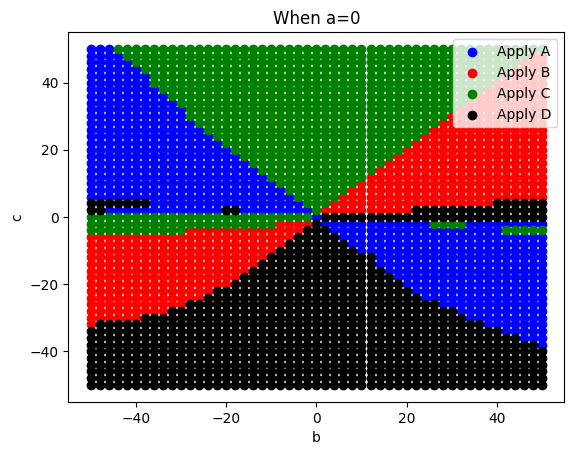

In [ ]:
# plot a vizualization of what we would predict for a bunch of ordered pairs

confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[0, i, j]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("b")
plt.ylabel("c")
plt.title("When a=0")
plt.legend()
plt.show()

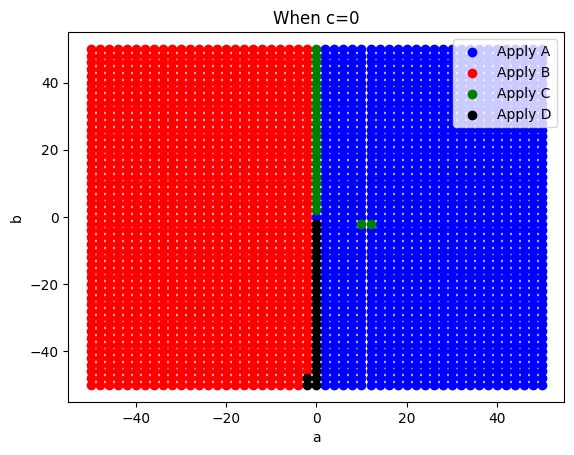

In [ ]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[i, 0, j]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("b")
plt.title("When c=0")
plt.legend()
plt.show()

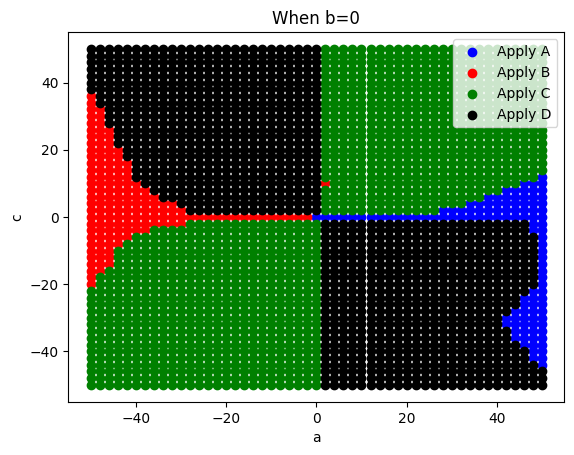

In [ ]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[i, j, 0]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("c")
plt.title("When b=0")
plt.legend()
plt.show()

In [ ]:
# B is the inverse of A
A = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]])

# C is the inverse of D
C = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = np.array([[1, 0, 0], [0, 1, -1], [0, 0, 1]])

identity = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [ ]:
# how long does it take us to get back to the origin? 
def matrix_to_tuple(matrix):
    return (matrix[0][1], matrix[0][2], matrix[1][2])

def num_steps_to_origin_w_nn(test_mat):
    for i in range(100):

        if (test_mat==A).all() or (test_mat==B).all() or (test_mat==C).all() or (test_mat==D).all():
            return i
        demo_test_type = torch.tensor([matrix_to_tuple(test_mat)], dtype=torch.float32)
        action = int(torch.argmax(trained_model(demo_test_type)))

        if action==0:
            test_mat = test_mat @ A
        elif action==1:
            test_mat = test_mat @ B
        elif action==2:
            test_mat = test_mat @ C
        else:
            test_mat = test_mat @ D

    return 1000

In [ ]:
test_mat = np.array([[1, 1, 1], [0, 1, 1], [0, 0, 1]])
num_steps_to_origin_w_nn(test_mat)

1000

In [ ]:
def apply_action(cur_matrix, action):
    if action==0:
        return cur_matrix @ A
    elif action==1:
        return cur_matrix @ B
    elif action==2:
        return cur_matrix @ C
    elif action==3:
        return cur_matrix @ D
    assert 1==2

In [ ]:
# going to get to the origin and track where we've been
already_seen = set()
start_matrix = np.array([[1, 5, -8], [0, 1, 1], [0, 0, 1]])
already_seen.add(matrix_to_tuple(start_matrix))

cur_matrix = start_matrix
i=0

while not (cur_matrix==identity).all():

    if i>10000:
        break

    demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
    action = int(torch.argmax(trained_model(demo_test_type)))

    new_mat = apply_action(cur_matrix, action)

    # if we're about to cycle
    if matrix_to_tuple(new_mat) in already_seen:
        action = int(trained_model(demo_test_type).topk(2, largest=True)[1][0][-1])
        new_mat = apply_action(new_mat, action)

        if matrix_to_tuple(new_mat) in already_seen:
            action = int(trained_model(demo_test_type).topk(3, largest=True)[1][0][-1])
            new_mat = apply_action(new_mat, action)

            if matrix_to_tuple(new_mat) in already_seen:
                action = int(torch.argmax(trained_model(demo_test_type)))
                new_mat = apply_action(new_mat, action)

                if matrix_to_tuple(new_mat) in already_seen:
                    action = random.randint(1, 4)
                    new_mat = apply_action(new_mat, action)

    
    cur_matrix = new_mat
    already_seen.add(matrix_to_tuple(cur_matrix))
    i+=1


# print(cur_matrix, i)

In [ ]:
def get_action(mat):
    demo_test_type = torch.tensor([matrix_to_tuple(mat)], dtype=torch.float32)
    return int(torch.argmax(trained_model(demo_test_type)))


In [ ]:
start_matrix = np.array([[1, 6, 21], [0, 1, -4], [0, 0, 1]])

print(get_action(start_matrix))
start_matrix = start_matrix @ D

print(get_action(start_matrix))
start_matrix = start_matrix @ B
# start_matrix = start_matrix @ C
# print(start_matrix)
print(get_action(start_matrix))
start_matrix = start_matrix @ B
# start_matrix = start_matrix @ C
# # print(start_matrix)
print(get_action(start_matrix))

# start_matrix = start_matrix @ A
print(start_matrix)
start_matrix = start_matrix @ B
print(start_matrix)

print(get_action(start_matrix))

start_matrix = start_matrix @ B
print(get_action(start_matrix))
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ B
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ B
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ B
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ B
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ B
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ C
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ C
print(start_matrix)
print(get_action(start_matrix))


start_matrix = start_matrix @ B
print(start_matrix)
print(get_action(start_matrix))

3
1
1
1
[[ 1  4 15]
 [ 0  1 -5]
 [ 0  0  1]]
[[ 1  3 15]
 [ 0  1 -5]
 [ 0  0  1]]
1
1
[[ 1  2 15]
 [ 0  1 -5]
 [ 0  0  1]]
1
[[ 1  1 15]
 [ 0  1 -5]
 [ 0  0  1]]
1
[[ 1  0 15]
 [ 0  1 -5]
 [ 0  0  1]]
1
[[ 1 -1 15]
 [ 0  1 -5]
 [ 0  0  1]]
1
[[ 1 -2 15]
 [ 0  1 -5]
 [ 0  0  1]]
1
[[ 1 -3 15]
 [ 0  1 -5]
 [ 0  0  1]]
2
[[ 1 -3 12]
 [ 0  1 -4]
 [ 0  0  1]]
2
[[ 1 -3  9]
 [ 0  1 -3]
 [ 0  0  1]]
1
[[ 1 -4  9]
 [ 0  1 -3]
 [ 0  0  1]]
0


In [ ]:
B@C@B@A

array([[ 1, -1, -1],
       [ 0,  1,  1],
       [ 0,  0,  1]])

In [ ]:
get_action(B@C@B@A)

1

In [ ]:
def matrix_to_num_steps(cur_matrix):
    index = 1
    for i in range(50):
        if (cur_matrix==A).all() or (cur_matrix==B).all() or (cur_matrix==C).all() or (cur_matrix==D).all():
            return i
        outputs = [0, 0, 0, 0]
        outputs[0] = Q_table[matrix_to_tuple(cur_matrix@ A)]
        outputs[1] = Q_table[matrix_to_tuple(cur_matrix@ B)]
        outputs[2] = Q_table[matrix_to_tuple(cur_matrix@ C)]
        outputs[3] = Q_table[matrix_to_tuple(cur_matrix@ D)]
        index = np.argmax(outputs)
        if index==0:
            cur_matrix = cur_matrix @ A
        elif index==1:
            cur_matrix = cur_matrix @ B
        elif index==2:
            cur_matrix = cur_matrix @ C
        elif index==3:
            cur_matrix = cur_matrix @ D
    return 100

In [ ]:
start_matrix = np.array([[1, 5, -8], [0, 1, 1], [0, 0, 1]])
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ C
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ A
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

start_matrix  = start_matrix @ B
print(start_matrix)
demo_test_type = torch.tensor([matrix_to_tuple(start_matrix)], dtype=torch.float32)
action = int(torch.argmax(trained_model(demo_test_type)))
action

[[ 1  5 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1  4 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1  3 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1  2 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1  1 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1  0 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1 -1 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1 -2 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1 -1 -3]
 [ 0  1  2]
 [ 0  0  1]]
[[ 1 -2 -3]
 [ 0  1  2]
 [ 0  0  1]]


0

In [ ]:
matrix_to_tuple(cur_matrix @ D) in already_seen

False

In [ ]:
demo_test_type = torch.tensor([[5, -8, -1]], dtype=torch.float32)
int(torch.argmax(trained_model(demo_test_type)))
trained_model(demo_test_type)

tensor([[1., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)

In [ ]:
def predicted_matrix(row):
    demo_test_type = torch.tensor([[int(row['val1']), int(row['val2']), int(row['val3'])]], dtype=torch.float32)
    return int(torch.argmax(trained_model(demo_test_type)))

test_df['predicted_matrix'] = test_df.apply(predicted_matrix, axis=1)

In [ ]:
test_df

,val1,val2,val3,last_matrix,first_move_by_Q_learning,predicted_matrix
0,6,-21,-4,1,2,2
1,-4,10,0,1,1,1
2,5,-8,1,4,1,2
3,3,1,-1,2,1,1
4,2,-2,-8,4,2,1
...,...,...,...,...,...,...
3969,-1,-3,7,4,3,3
3970,8,-2,0,3,1,1
3971,-3,1,-3,3,0,0
3972,3,-3,-1,4,2,1


In [ ]:
row2 = test_df.sample(1)

int(row2['val2'])

43

In [ ]:

action

3

In [ ]:
demo_test_type = torch.tensor([[1, 0, 1]], dtype=torch.float32)
confidence = int(torch.argmax(trained_model(demo_test_type)))